# VAR Bayesiano (BVAR)
Seguiremos a [BGR2010](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137) en su propuesta Large BVAR

Los autores introducen el prior de Litterman (o Minnesota Prior) con observación 'dummy' al inicio de la muestra

In [1]:
import numpy as np # Algebra matricial
import datetime as dt
import pandas as pd
import random # Simulacion aleatoria
import matplotlib.pyplot as plt # gráficos
import time
import sys

## Añadir librería creada
Añadir la librería creada para esta parte del curso

In [2]:
flag_runlocal  = False    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con conexión a internet via proxy

In [3]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import VARstuff

ModuleNotFoundError: No module named 'ConfigProxy'

1. Cargar la data (disponible [aquí](http://qed.econ.queensu.ca/jae/datasets/banbura001/))

In [ ]:
df_raw = pd.read_csv(pathBayesInver + '03_Inputs/bgrdata.csv')
df_info = pd.read_csv(pathBayesInver + '03_Inputs/info.csv')

In [ ]:
df_raw.head()

In [ ]:
OrderFinal = df_info.Mnemon.values
k0 = OrderFinal.size

df_ordered = df_raw[OrderFinal].copy()
df_ordered.head()

In [ ]:
TakeLog = df_info['Log'].values.astype(bool)
for ii in range(k0):
    if TakeLog[ii]:
        df_ordered[OrderFinal[ii]] = np.log(df_ordered[OrderFinal[ii]])

df_ordered.head() ## Recorre la base y le saca el logaritmo

In [ ]:
df_final = df_ordered.copy()
df_info_final = df_info.copy()

In [ ]:
T = df_final.CES002.size
T

In [ ]:

H = 12 ## importante porque deseo proyectar
df_estimate = df_final[0:(T-H)].copy() #estimar
df_eval = df_final[(T-H-1):T].copy()#evaluar,la base se divide la primera observación de uno sera la ultima de otro

2. Preparando los datos para procedimientos Bayesianos

In [ ]:
lag = 13 ## rezagos
k = df_final.columns.size
data2est = df_estimate.values #numpy
y,X,k,Tf = VARstuff.get_yXform(data2est,lag)

y2e = df_eval.values

3. Estimación y pronóstico simple

In [ ]:
Bhat,Sigmahat,yhat,uhat = VARstuff.get_MCO_VAR(y,X) ## estima el MCO
Xtp1 = X[Tf-1,:] ## extrae la ultima fila de la matriz X
y_data = y2e ## almacena datos de evaluacion
y_data_first = y2e[0,:] #extrae la primera fila de los datos de evaluación
y_data_first.shape = (1,k) # lo pasa a una matriz

In [ ]:
u_zero = np.zeros(shape=(H,k)) #crea matriz de 0
y_zero,_ = VARstuff.get_sim_VAR(Xtp1,u_zero,Bhat,lag) #usa la ultima observacion que contiene los ultimos regresores de la estimacion y el Bhat,lag
y_zero = np.r_[y_data_first,y_zero] ## almacenamos las simulaciones

4. Concentremonos en las variables correspondientes a CEE2005

In [ ]:
CEEindex0 = df_info_final['CEE'].values.astype(bool)
aux0 = CEEindex0.nonzero()
CEEindex = aux0[0]
CEEname  = df_final.columns[CEEindex0] # separo las variables que usare de las que no usare

In [ ]:
##Grafico lo estimado
fig, axs = plt.subplots(2,4,figsize=(10,7))
ff = 0
for rr in range(2):
    for cc in range(4):
        if ff<7:
            axs[rr,cc].plot(y_data[:,CEEindex[ff]],'k')
            axs[rr,cc].plot(y_zero[:,CEEindex[ff]],'b')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

plt.tight_layout()

5. Extendiendo la data con observaciones 'dummy' (BGR2012 sugieren $\tau=10\lambda$)

In [ ]:
# Minnesota prior
lmbda = 0.035 ## Se pueden usar dummys,construir un y y x de tal forma (pag14) qiue es similar a una prior
deltas = df_info_final['RW'].values ##esto es dado
sigmas = VARstuff.get_sigmas(data2est,lag) ## necesitamos estos valores.Se necesitara maximizar la verosimilitud en el trabajo
yd0,Xd0,Td = VARstuff.get_DumObsLitterman(lmbda,deltas,sigmas,lag) ## obtendremos un y y un x

# Sum of coefficients prior
tau = 10*lmbda #parametors
mus = np.mean(data2est,0) #captan el nivel promedio de la variable
yd1,Xd1,Td1 = VARstuff.get_DumObsSumCoef(tau, mus, sigmas, lag) #calcula dummys

# data extended
y_star = np.r_[yd0,yd1,y] # datos extendidos + datos reales
X_star = np.r_[Xd0,Xd1,X]

6. Some posterior moments

In [ ]:
Bayes = True
B_post,Sigma_post,_,_ = VARstuff.get_MCO_VAR(y_star,X_star,Bayes) #el bayes estima la matriz de varianza de los residuos.Interes en sigma y beta posterior
Tf_post,d = X_star.shape
Dof_post = Tf_post-k # Tf_post-d ? ## grados de livbertad
LT_SS_post = np.linalg.cholesky(Sigma_post) #descomposiicon de cholesky
XX_star = np.dot(np.transpose(X_star),X_star)
LT_P_post =  VARstuff.get_iXXchol(XX_star) #inversa de la matriz

7. Pronóstico simple (como en BGR2010)

In [ ]:
y_zero_m,_ = VARstuff.get_sim_VAR(Xtp1,u_zero,B_post,lag) #le dimos un beta posterior
y_zero_m = np.r_[y_data_first,y_zero_m]

8. Pronóstico Bayesiano

In [ ]:
random.seed( 0 )    # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
Fore_BVAR = VARstuff.get_BVARforvast(y_data_first,Xtp1,lag,H,100,1000,B_post,LT_SS_post,LT_P_post,Dof_post) #data de evaluación,vector de regresores,lag del bar,horizonte,100=observacione quedads,1000=quedar,Bposterior,descomposicion de cholesku,inversa de la matriz x transpuesta,grados de libertad.Pronostico bayesiano
#Fore_BVAR = VARstuff.get_BVARforvast(y_data_first,Xtp1,lag,H,10,100,B_post,LT_SS_post,LT_P_post,Dof_post)

#get BVar forecast simula

[                                                  ]
[--------------------------------------------------]



In [ ]:
Fore_BVAR_Q95  = np.percentile(Fore_BVAR, 95, axis=2)
Fore_BVAR_Q05  = np.percentile(Fore_BVAR,  5, axis=2)
Fore_BVAR_mean = np.mean(Fore_BVAR,axis=2) #se calculan los percentiles

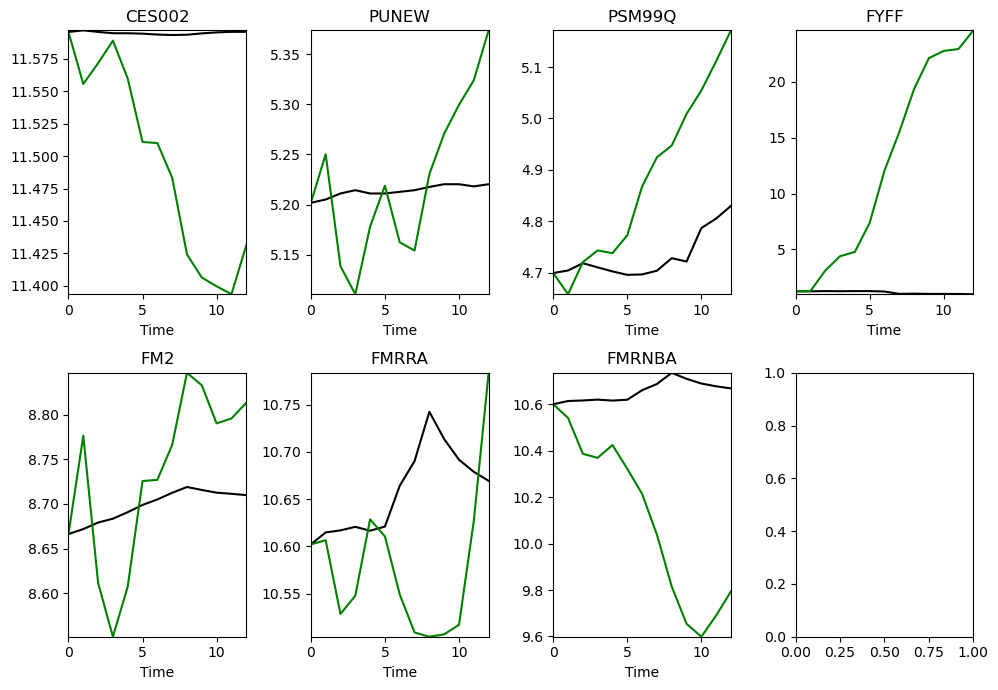

In [ ]:
#linea verde bayesianos y negro reales
fig, axs = plt.subplots(2,4,figsize=(10,7))
ff = 0
for rr in range(2):
    for cc in range(4):
        if ff<7:
            axs[rr,cc].plot(y_data[:,CEEindex[ff]],'k')
            #axs[rr,cc].plot(y_zero_m[:,CEEindex[ff]],'b')
            axs[rr,cc].plot(Fore_BVAR_mean[:,CEEindex[ff]],'g')
            #axs[rr,cc].plot(Fore_BVAR_Q95[:,CEEindex[ff]],'r')
            #axs[rr,cc].plot(Fore_BVAR_Q05[:,CEEindex[ff]],'r')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

plt.tight_layout()

In [ ]:
# calcula el error de estimacion
Ferror_freq = np.linalg.norm(y_data-y_zero)/y_data.size
Ferror_simple = np.linalg.norm(y_data-y_zero_m)/y_data.size
Ferror_bayes = np.linalg.norm(y_data-Fore_BVAR_mean)/y_data.size
print('Freq:')
print(Ferror_freq)
print('')
print('Simple:')
print(Ferror_simple)
print('Bayes:')
print(Ferror_bayes)

Freq:
0.29320952139492434

Simple:
0.2331719552937364
Bayes:
1.9879806306647057


9. IRF
Similar a CEE

In [ ]:
aux0=df_final.columns=='FYFF'
aux0 = aux0.nonzero()
shock = aux0[0]+1 # como el sistema de numeracion en python inicia en 0 entonces 1
scale = 1
## los que sonn 0 se van

In [ ]:
Bhat, Sigmahat, _, uhat = VARstuff.get_MCO_VAR(y, X)

In [ ]:
h=4*12
b=1
r=50
nsample = 50
random.seed( 0 )    # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
#IRF = VARstuff.get_IRF_Chol_BT(y_star,X_star,k,Tf,nsample,h,shock,lag,scale)
startC = time.time()
IRF = VARstuff.get_IRF_Chol_BVAR(lag,h,b,r,B_post,LT_SS_post,LT_P_post,Dof_post,95,scale) ## computo el impulso respuesta
endC = time.time()
print('Time elapsed:',endC-startC)


[                                                  ]
[----------------------------------------------------]

Time elapsed: 18.156120538711548


In [ ]:
IRF_Q95  = np.percentile(IRF, 95, axis=2)
IRF_Q05  = np.percentile(IRF,  5, axis=2)
IRF_mean = np.mean(IRF,axis=2)

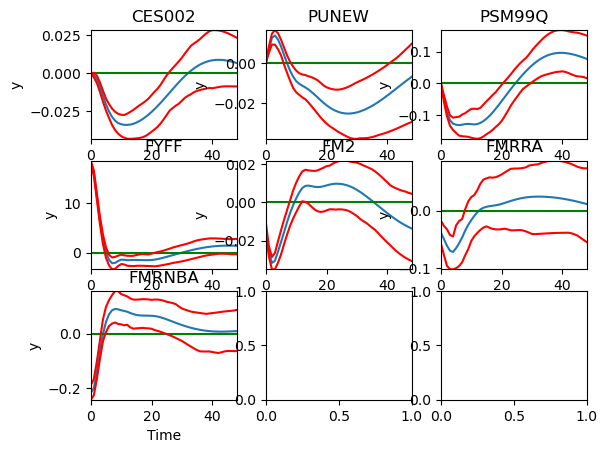

In [ ]:
fig, axs = plt.subplots(3,3)

ff = 0
for rr in range(3):
    for cc in range(3):
        if ff<7:
            axs[rr,cc].plot(IRF_mean[CEEindex[ff],:]*100)
            axs[rr,cc].axhline(0, color='green')
            axs[rr,cc].plot(IRF_Q95[CEEindex[ff],:]*100,'r')
            axs[rr,cc].plot(IRF_Q05[CEEindex[ff],:]*100,'r')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_ylabel('y')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

#plt.tight_layout()

In [ ]:
np.asarray([VARstuff.Hyper_ML(np.asarray([lmbda-0.01]), X, y, sigmas, deltas), VARstuff.Hyper_ML(np.asarray([lmbda]), X, y, sigmas, deltas), VARstuff.Hyper_ML(np.asarray([lmbda+0.5]), X, y, sigmas, deltas)])

array([-161847.20802211, -154775.31147269,  -16766.51222147])

# Reference
> Banbura, Giannone y Reichlin (2010), *Large Bayesian vector auto regressions*. Journal of Applied Econometrics, John Wiley & Sons, Ltd., vol. 25(1), pages 71-92, January. [https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137)
